# Corpus Generator
Generates a corpus for training 

In [30]:
import pymongo
from pymongo import MongoClient
import nltk
from nltk.corpus import stopwords
import json
import string
import codecs
import gensim 
from gensim import corpora, models
from collections import Counter
import re
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import nltk.stem
import os
punct_filter = [u'"',u'#',u'$',u'%',u'&',u'\\',u"'",u'(',u')',u'*',u'+',u',',u'.',u'/',
     u'-',u':',u';',u'<',u'=',u'>',u'?',u'@',u'[',u']',u'^',u'_',u'`',u'{',
     u'|',u'}',u'–',u'\u2013',u'\u2010',u'\u2606',u'\u22C5',u'\u201D',u'\u2248',u'\u21CC',u'\u223C',u'\u2212',u'\u2014',u'\u2032',u'\u2018',u'\u2019',u'\u2022',u'\u2020',u'\u00B0',u'\u201C',u'\u29B9',u'\uFF0D',u'\u2261']
stop = stopwords.words('english')
with open('chemistry_stopwords.json') as f:
    chem_stop = json.load(f)
max_stop = stop+chem_stop
mongo_url = 'mongodb://localhost:6666/'
#mongo_url = 'mongodb://localhost:27017/'
db = 'Cherry'
coll_in = 'Cranberry'
client = MongoClient(mongo_url)
ch = client[db][coll_in]
coops = client[db]['raspberry']
#corpusfile = 'corpus2.txt' 

In [31]:
class GensimCorpus(object):
    def __init__(self,corpus_text_file,diction):
        self.corpus_text_file = corpus_text_file
        self.dictionary = diction
        
    def __iter__(self):
        for line in open(self.corpus_text_file):
            yield self.dictionary.doc2bow(line.split())

def dictionary_generator(corpus_file):
    dictionary = corpora.Dictionary(line.split() for line in open(corpus_file))
    return dictionary

def create_models(corpus_file):
    dictionary = dictionary_generator(corpus_file)
    print('Created Dictionary')
    corp = GensimCorpus(corpus_file,dictionary)
    print('Created Corpus Object')
    tfidf = models.TfidfModel(corp)
    print('Created TFIDF Model')
    tfidf_corp = tfidf[corp]
    print('Created TFIDF Corpus')
    return dictionary,corp,tfidf,tfidf_corp

def load_models(dictionary_file,corpus_file,tfidf_file):
    dictionary = corpora.Dictionary.load(dictionary_file)
    corp = GensimCorpus(corpus_file,dictionary)
    tfidf = models.TfidfModel.load(tfidf_file)
    tfidf_corp = tfidf[corp]
    return dictionary,corp,tfidf,tfidf_corp

def tfidf_filtered_corpus_generator(corpus_filename,threshold):
    corpus_filename = 'tfidf_filtered_'+str(threshold).strip('.')+'.txt'
    ind=0
    with codecs.open(corpus_filename,'a',encoding='utf8') as f:
        for doc in tfidf_corp:
            if ind%500000 == 0:
                print(ind)
            f.write(' '.join([dictionary[i] for i,j in doc if j>=threshold]))
            f.write('\n')
            ind+=1

def remove_unicode_punct(subj, chars):
    return re.sub(u'(?u)[' + re.escape(''.join(chars)) + ']', ' ', subj)
                
def create_cranberry_corpus(file_name,sanitizer):
    ind = 0 
    with codecs.open(file_name,'a',encoding='utf8') as f:
        for rec in ch.find({'crossref_doi':True}):
            ex = sanitizer(rec['title'])+u'\n'
            f.write(export)
            ind+=1
            if ind%100000==0:
                print(ind)
    
def create_raspberry_corpus(file_name,sanitizer):
    ind = 0 
    with codecs.open(file_name,'a',encoding='utf8') as f:
        for rec in coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"}):
            san_title = sanitizer(rec['title'])
            san_abs = sanitizer(rec['abstract'])
            f.write(san_title+' '+san_abs+'\n')
            ind+=1
            if ind%10000==0:
                print(ind)

In [32]:
####Filterers

def stop_word_sanitise(title,stops):
    #lower case, strip whitespace and carriages, remove stopwords, remove punctuation
    lt = title.lower()
    slt = lt.strip()
    tslt = remove_unicode_punct(slt,punct_filter)
    stop_filtered = [i for i in tslt.split() if i not in stops]
    export = u' '.join(stop_filtered)
    return export

def minimal_sanitise(title):
    #lower case, strip whitespace and carriages, remove punctuation
    lt = title.lower()
    slt = lt.strip()
    tslt = remove_unicode_punct(slt,punct_filter)
    export = tslt.strip()
    return export

def stemming_sanitise(title,stops,stemmer):
    #lower case, strip whitespace and carriages, remove punctuation, remove stopwords, stem
    lt = title.lower()
    slt = lt.strip()
    tslt = remove_unicode_punct(slt,punct_filter)
    stop_filtered = [i for i in tslt.split() if i not in stops]
    stem_filtered = [stemmer.stem(i) for i in stop_filtered]
    export = u' '.join(stem_filtered)
    return export
    
def lemmatizing_sanitise(title,stops,lemmatizer):
    #lower case, strip whitespace and carriages, remove punctuation, remove stopwords, lemmatize
    lt = title.lower()
    slt = lt.strip()
    tslt = remove_unicode_punct(slt,punct_filter)
    stop_filtered = [i for i in tslt.split() if i not in stops]
    lemma_filtered = [lemmatizer.lemmatize(words) for words in stop_filtered]
    export = u' '.join(lemma_filtered)
    return export

In [33]:
def get_corpus_stats(in_file,diction,outfile_name):
    unique_word_count=0
    for k in diction.iterkeys():
        if unique_word_count<k:
            unique_word_count=k
    print('Counted Unique Words')
    word_freq = Counter()
    word_count = 0
    document_count = 0
    document_lengths = Counter()
    interim_corp = GensimCorpus(in_file,diction)
    ind=0
    for doc in interim_corp:
        word_count+=sum(zip(*doc)[1])
        document_count+=1
        document_lengths.update([sum(zip(*doc)[1])])
        upd = []
        for w_id,w_freq in doc:
            upd+=([w_id]*w_freq)
        word_freq.update(upd)
        ind+=1
        if ind%10000==0:
            sys.stdout.write('\r[{0}] {1}'.format('#'*(ind/10000), ind))
            sys.stdout.flush()
    mean_doc_length = float(word_count)/float(document_count)
    mode_doc_length = document_lengths.most_common(1)[0]
    print('\nGenerated Counting Stats')
    ranked_word_freq = word_freq.most_common()
    ziphian_table = []
    for rank in range(unique_word_count):
        w = dictionary[ranked_word_freq[rank][0]].encode('utf-8')
        r = rank+1
        log_r = math.log(r,10)
        f = ranked_word_freq[rank][1]
        log_f = math.log(f,10)
        ziphian_table.append((w,r,log_r,f,log_f))
    print('Generated Ziphian Data')
    sample = []
    log_ranks = list(zip(*ziphian_table)[2])
    for s in np.arange(ziphian_table[0][2],ziphian_table[-1][2],ziphian_table[1][2]):   
        sample.append(log_ranks.index(min(log_ranks,key=lambda x:abs(x-s))))
    z_grad,z_c = np.polyfit([ziphian_table[s][2] for s in sample],[ziphian_table[s][4] for s in sample],1)
    line_freq = map(lambda x: z_grad*x+z_c,log_ranks)
    plt.close()
    plt.plot(log_ranks,list(zip(*ziphian_table)[4]),'r')
    plt.plot(log_ranks,line_freq,'b')
    plt.savefig(outfile_name+'_ziphian_plot.png')
    print('Saved Ziphian Plot')
    plt.close()
    plt.plot(document_lengths.keys(),document_lengths.values(),'o')
    plt.savefig(outfile_name+'_document_word_lengths.png')
    plt.close()
    print('Saved Document Length Distribution Plot')
    with open(outfile_name+'_ziphian_data.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['word','rank','log rank','freqency','log_frequncy'])
        writer.writerows(ziphian_table)
    print('Writen Ziphian Data To file')
    with open(outfile_name+'_document_lengths.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['words per document','number of documents'])
        writer.writerows(zip(document_lengths.keys(),document_lengths.values()))
    print('Writen Document Length Distribution data to file')
    with open(outfile_name+'stats.txt','wb') as f:
        f.write('Word count : '+str(word_count)+'\n')
        f.write('Unique words : ' + str(unique_word_count)+'\n')
        f.write('Mean document word count : ' + str(mean_doc_length)+'\n')
        f.write('Mode document word count : '+ str(mode_doc_length[0])+'\n')
        f.write('Document count : ' + str(document_count)+'\n')
        f.write('Ziphian gradient : '+str(z_grad)+'\n')
        f.write('Ziphian intercept : '+str(z_c)+'\n')
        f.write('most_frequent 10 words : '+'\n')
        for w in ziphian_table[0:10]:
            f.write('"'+w[0]+'" : '+str(w[3])+' occurances\n')
    print('Written stats report to file')

In [202]:
stemmer = nltk.stem.snowball.EnglishStemmer()
create_raspberry_corpus('stemmed_raspberry_corpus.txt',lambda x: stemming_sanitise(x,max_stop,stemmer))
dictionary, corpus, tfidf_model,tfidf_corpus = create_models('stemmed_raspberry_corpus.txt')
dictionary.save('stemmed_raspberry_dictionary')
tfidf_model.save('stemmed_raspberry_tfidf_model')
tfidf_corpus.save('stemmed_raspberry_tfidf_corpus')
#dictionary,corp,tfidf,tfidf_corp = load_models('raw_raspberry_dictionary','raw_raspberry_corpus.txt','raw_raspberry_tfidf_model')
get_corpus_stats('stemmed_raspberry_corpus.txt',dictionary,'stemmed_raspberry')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
Created Dictionary
Created Corpus Object
Created TFIDF Model
Created TFIDF Corpus
Counted Unique Words
[############################################] 440000
Generated Counting Stats
Generated Ziphian Data
Saved Ziphian Plot
Saved Document Length Distribution Plot
Writen Ziphian Data To file
Writen Document Length Distribution data to file
Written stats report to file


In [34]:
def compare_stemmers(dictionary,outfile_name):
    it = dictionary.iteritems()
    lancaster_reps=0
    porter_reps=0
    snowball_reps=0
    wordnet_reps=0
    lancaster_porter_agreements = 0
    lancaster_snowball_agreements = 0
    lancaster_wordnet_agreements = 0
    porter_snowball_agreements = 0
    porter_wordnet_agreements = 0
    snowball_wordnet_agreements=0
    ind=0
    with open(outfile_name, 'wb') as f:
        writer = csv.writer(f, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['word','lancaster','porter','snowball','wordnet'])
        for w_id,w in it:
            wl = lancaster.stem(w)
            wp = porter.stem(w)
            ws = snowball.stem(w)
            ww = wordnet.lemmatize(w)
            wl_fire = w!=wl
            wp_fire = w!=wp
            ws_fire = w!=ws
            ww_fire = w!=ww
            lancaster_reps+=int(wl_fire)
            porter_reps+=int(wp_fire)
            snowball_reps+=int(ws_fire)
            wordnet_reps+=int(ww_fire)
            if (wl_fire|wp_fire|ws_fire|ww_fire):
                row = [w.encode('utf-8'),'','','','']
                if wl_fire: row[1]=wl.encode('utf-8')
                if wp_fire: row[2]=wp.encode('utf-8')
                if ws_fire: row[3]=ws.encode('utf-8')
                if ww_fire: row[4]=ww.encode('utf-8')
                writer.writerow(row)
                lancaster_porter_agreements +=int(wl==wp)
                lancaster_snowball_agreements +=int(wl==ws)
                lancaster_wordnet_agreements +=int(wl==ww)
                porter_snowball_agreements +=int(wp==ws)
                porter_wordnet_agreements +=int(wp==ww)
                snowball_wordnet_agreements +=int(ws==ww)
            if ind%10000==0:
                sys.stdout.write('\r[{0}] {1}'.format('#'*(ind/10000), ind))
                sys.stdout.flush()
            ind+=1
    print('finished')
    print('lancaster replacements: '+str(lancaster_reps))
    print('porter replacements: '+str(porter_reps))
    print('snowball replacements: '+str(snowball_reps))
    print('wordnet replacements: '+str(wordnet_reps))
    print('lancaster_porter_agreements: ' + str(lancaster_porter_agreements))
    print('lancaster_snowball_agreements: ' +str(lancaster_snowball_agreements))
    print('lancaster_wordnet_agreements: '+str(lancaster_wordnet_agreements))
    print('porter_snowball_agreements: '+str(porter_snowball_agreements))
    print('porter_wordnet_agreements: '+str(porter_wordnet_agreements))
    print('snowball_wordnet_agreements: '+str(snowball_wordnet_agreements))

In [13]:
#create_raspberry_corpus('corpnatural.txt',minimal_sanitise)
dictionary, corpus, tfidf_model,tfidf_corpus = create_models('corpnatural.txt')
dictionary.save('corpnatural_dictionary')
tfidf_model.save('corpnatural_tfidf_model')
tfidf_corpus.save('corpnatural_tfidf_corpus')
#dictionary,corp,tfidf,tfidf_corp = load_models('raw_raspberry_dictionary','raw_raspberry_corpus.txt','raw_raspberry_tfidf_model')
get_corpus_stats('corpnatural.txt',dictionary,'corpnatural')

Created Dictionary
Created Corpus Object
Created TFIDF Model
Created TFIDF Corpus
Counted Unique Words
[##########] 100000
Generated Counting Stats
Generated Ziphian Data
Saved Ziphian Plot
Saved Document Length Distribution Plot
Writen Ziphian Data To file
Writen Document Length Distribution data to file
Written stats report to file


In [9]:
sentence_lens=[]
for rec in coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"})[0:1000]:
    abst = rec['abstract']
    '''if len(abst.split(u'. '))>20:
        lens = map(lambda x: len(x),abst.split(u'. '))
        for sent in abst.split(u'. '):
            if len(sent.split(u' '))<6:
                print(unicode(sent) +u' : ' +str(len(sent.split(u' '))))'''
    sents = abst.split(u'. ')
    for sent in sents:
        s = [i for i in sent.split(' ') if i != '']
        if len(s)==5:
            print(' '.join(s))

traditional colorimetry with Fujiwara reaction2)
Thus as shown in Fig
was formed abundantly in soil
2420m) make a little difference
lipid, protein, and nucleic acid
superoxide dismutase (SOD) and catalase
泌乳牛が暑熱ストレスを受けた場合，どの血液成分が，どのように変化するかを明らかにすると共に，飼料摂取状況や乳生産性との関連性を検討するため，乳牛45頭を分離給与または完全混合飼料（TMR）給与で飼養管理し，１年間に渡って毎月代謝プロファイルテストを実施した．得られた延べ277頭のデータを給与法毎に適温期と暑熱期（６～９月）に分け，各調査項目を比較した．分離給与では適温期に延べ81頭，暑熱期に延べ43頭のデータが得られた．これらを比較した結果，乾物摂取量（DMI, p<0.05），代謝エネルギー摂取量（p<0.01），乳量（p<0.01），乳脂率（p<0.05），乳蛋白質率（p<0.001），ヘマトクリット（Ht, p<0.001），血糖（p<0.001），血清総コレステロール（p<0.01），リン脂質（p<0.001），総蛋白質（p<0.05），カルシウム（p<0.01）およびアスパラギン酸アミノトランスフェラーゼ（AST, p<0.05）が暑熱期に有意な低値を示し，血清β-リポ蛋白（BL, p<0.001）が有意な高値を示した．一方，TMR給与では適温期に延べ110頭，暑熱期に延べ43頭のデータが得られた．これらを比較した結果，飼料摂取状況と乳量に差はなかったが，乳脂率（p<0.05）と乳蛋白質率（p<0.01），Ht（p<0.001）および血清AST（p<0.01）が暑熱期に有意な低値を示し，血清BL（p<0.001）とアルブミン（p<0.01）が有意な高値を示した．以上のように，分離給与では暑熱期にDMIと乳量が低下し，血液成分は13項目中８項目に変化がみられた．一方，TMR給与では暑熱期でもDMIと乳量が低下せず，血液成分は４項目にのみ変化がみられた．従って，暑熱による泌乳牛の血液成分の変化は飼料摂取状況や乳生産性が受けた影響によって異なることが示唆された

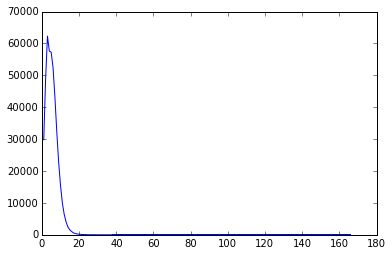

In [36]:
c = Counter(sentence_no)
plt.plot(c.keys(),c.values())
plt.show()

In [35]:
%matplotlib inline

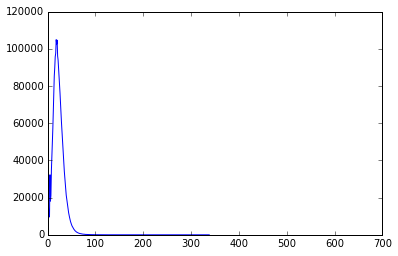

In [64]:
cc = Counter(sentence_lens)
plt.plot(cc.keys(),cc.values())
plt.xlim(0,700)
plt.show()

In [65]:
cc

Counter({0: 17708,
         1: 27192,
         2: 13993,
         3: 12898,
         4: 9574,
         5: 32254,
         6: 18110,
         7: 21203,
         8: 34770,
         9: 42265,
         10: 51009,
         11: 57255,
         12: 66710,
         13: 75689,
         14: 85365,
         15: 89844,
         16: 95778,
         17: 97526,
         18: 104899,
         19: 102533,
         20: 104612,
         21: 96155,
         22: 93940,
         23: 89684,
         24: 85387,
         25: 80805,
         26: 76236,
         27: 70850,
         28: 65507,
         29: 60647,
         30: 56084,
         31: 50918,
         32: 46655,
         33: 41930,
         34: 38346,
         35: 34137,
         36: 30713,
         37: 27587,
         38: 24422,
         39: 21296,
         40: 19365,
         41: 17137,
         42: 15085,
         43: 13544,
         44: 11873,
         45: 10459,
         46: 9299,
         47: 8200,
         48: 7090,
         49: 6265,
         50:

In [55]:
s='The humite group minerals and HyM-α proposed in this study make a homologous series as recombination structures: Mg(2                                                          m                                                        +                                                          n                                                        )Si                              m                            H2                                                          n                            O2(2                                                          m                                                        +                                                          n                                                        ) for the humite group and Mg(2                                                          m                                                        +                                                          n                                                        )Si(                                                          m                                                        +                                                          n                                                        )H2                                                          n                            O4(                                                          m                                                        +                                                          n                                                        ) for HyM-α A characteristic feature is that Mg/Si > 2 for the humite group and Mg/Si < 2 for HyM-α'

In [62]:
' '.join([i for i in s.split(' ') if i != ''])

'The humite group minerals and HyM-\xce\xb1 proposed in this study make a homologous series as recombination structures: Mg(2 m + n )Si m H2 n O2(2 m + n ) for the humite group and Mg(2 m + n )Si( m + n )H2 n O4( m + n ) for HyM-\xce\xb1 A characteristic feature is that Mg/Si > 2 for the humite group and Mg/Si < 2 for HyM-\xce\xb1'

In [56]:
def generate_final_corpus(filename,sanitise_fun,min_raw_threshold):
    foreign_nos=0
    ind=0
    with codecs.open(filename,'w',encoding='utf8') as f:
        recs = coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"}).count()
        for rec in coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"}):
            export = {'title':'','abstract':[]}
            title = rec['title'] 
            abst = rec['abstract']
            sents = abst.split(u'. ')
            sents_lists = map(lambda sent: [i for i in sent.split(' ') if i != ''],sents)
            sents = [' '.join(s) for s in sents_lists if len(s)>=min_raw_threshold]
            foreign = False
            k=0
            for sent in sents:
                if foreign:break
                foreign = detect_foreign(sents[k])
                k+=1
            if foreign: foreign_nos+=1
            if not foreign:
                export['title'] = sanitise_fun(title)
                export['abstract'] = [sanitise_fun(s) for s in sents]
                ex = json.dumps(export)
                f.write(ex)
                f.write('\n')
            if ind%10000==0:
                percent = int(100*float(ind)/recs)
                sys.stdout.write('\r[{0}] {1}%'.format('#'*(percent/10), percent))
                sys.stdout.flush()
            ind+=1
    return foreign_nos

In [53]:
san = lambda x: stemming_sanitise(x,max_stop,nltk.stem.snowball.EnglishStemmer())
foreign_removals = generate_final_corpus('exp2.json',san,5)

[#########] 97%

In [52]:
def detect_foreign(sent):
    foreign_param = 0.28
    unicode_text=len(list(re.sub('[\x00-\x7f]', '',sent)))
    word_text= len(list(sent.replace(' ','')))
    unicode_fraction = float(unicode_text)/word_text 
    foreign_bool= unicode_fraction>foreign_param
    if foreign_bool:
        with codecs.open('no_nos_final.txt','a',encoding='utf8') as f:
            f.write(sent)
    return foreign_bool
        

In [14]:
def remove_china(value):
    fired=0
    ind=0
    print('starting run')
    print()
    f=codecs.open('no nos'+str(value)+'.txt','a',encoding='utf8')
    recs = coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"}).count()
    for rec in coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"}):
        abst = rec['abstract']
        sents = abst.split(u'. ')
        sents_lists = map(lambda sent: [i for i in sent.split(' ') if i != ''],sents)
        sents = [' '.join(s) for s in sents_lists if len(s)>=5]
        for sent in sents:
            chin=len(list(re.sub('[\x00-\x7f]', '',sent)))
            word_c= len(list(sent.replace(' ','')))
            chin_prob = float(chin)/word_c 
            if chin_prob>value:
                fired+=1
                f.write(sent + u'\n')
                #print(sent[0:60])
        if ind%1000==0:
            percent = int(100*float(ind)/recs)
            sys.stdout.write('\r[{0}] {1}% {2}'.format('#'*(percent/10), percent, ind))
            sys.stdout.flush()
        ind+=1
    f.close()
    return fired

In [23]:
values = [0.28,0.26,0.24,0.22]
fireds = []
for v in values:
    fireds.append(remove_china(v))

starting run
()
[#########] 99% 449000starting run
()
[#########] 99% 449000starting run
()
[#########] 99% 449000starting run
()
[#########] 99% 449000

In [69]:
word_lens = []
ccc=Counter()
ind=0
recs = coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"}).count()
for rec in coops.find({'abstract': {'$exists': True}, '$where': "this.abstract.length>0"}):
    abst = rec['abstract']
    word_lens = [len(list(i)) for i in abst.split(u' ')]
    ccc.update(word_lens)
    if ind%1000==0:
        percent = int(100*float(ind)/recs)
        sys.stdout.write('\r[{0}] {1}% {2}'.format('#'*(percent/10), percent, ind))
        sys.stdout.flush()
    ind+=1

[#########] 99% 449000

In [16]:
fireds

[193, 471, 698]

In [20]:
fireds

[781, 815, 832, 845, 1000, 5096]

In [22]:
fireds = [193, 471, 698,781, 815, 832, 845, 1000, 5096]

In [24]:
fireds

[850, 863, 887, 939]

In [25]:
# use chinese filter 0.28!

In [54]:
foreign_removals

778